# Dataset Preprocessing
### Outline of Preprocessing Steps
- Discover and Visualize
	- Inspect
	- Histogram
	- Look for Correlations
	- Boxplot
- Experimenting with Attribute Combinations
- Prepare for Machine Learning Algorithms:
	- Data Cleaning
		- Remove duplicates
		- Fix incorrect data types
		- Standardize column names ( optional )
	- Handle Missing Values
	- Handle Text and Categorical Attributes
	- Handle Outliers
	- Feature Scaling
	- Feature Engineering ( optional )
	- Dimensionality Reduction
	- Handling Imbalanced Data ( for classification )
	- Train-Test Split

#### Discover and Visualize

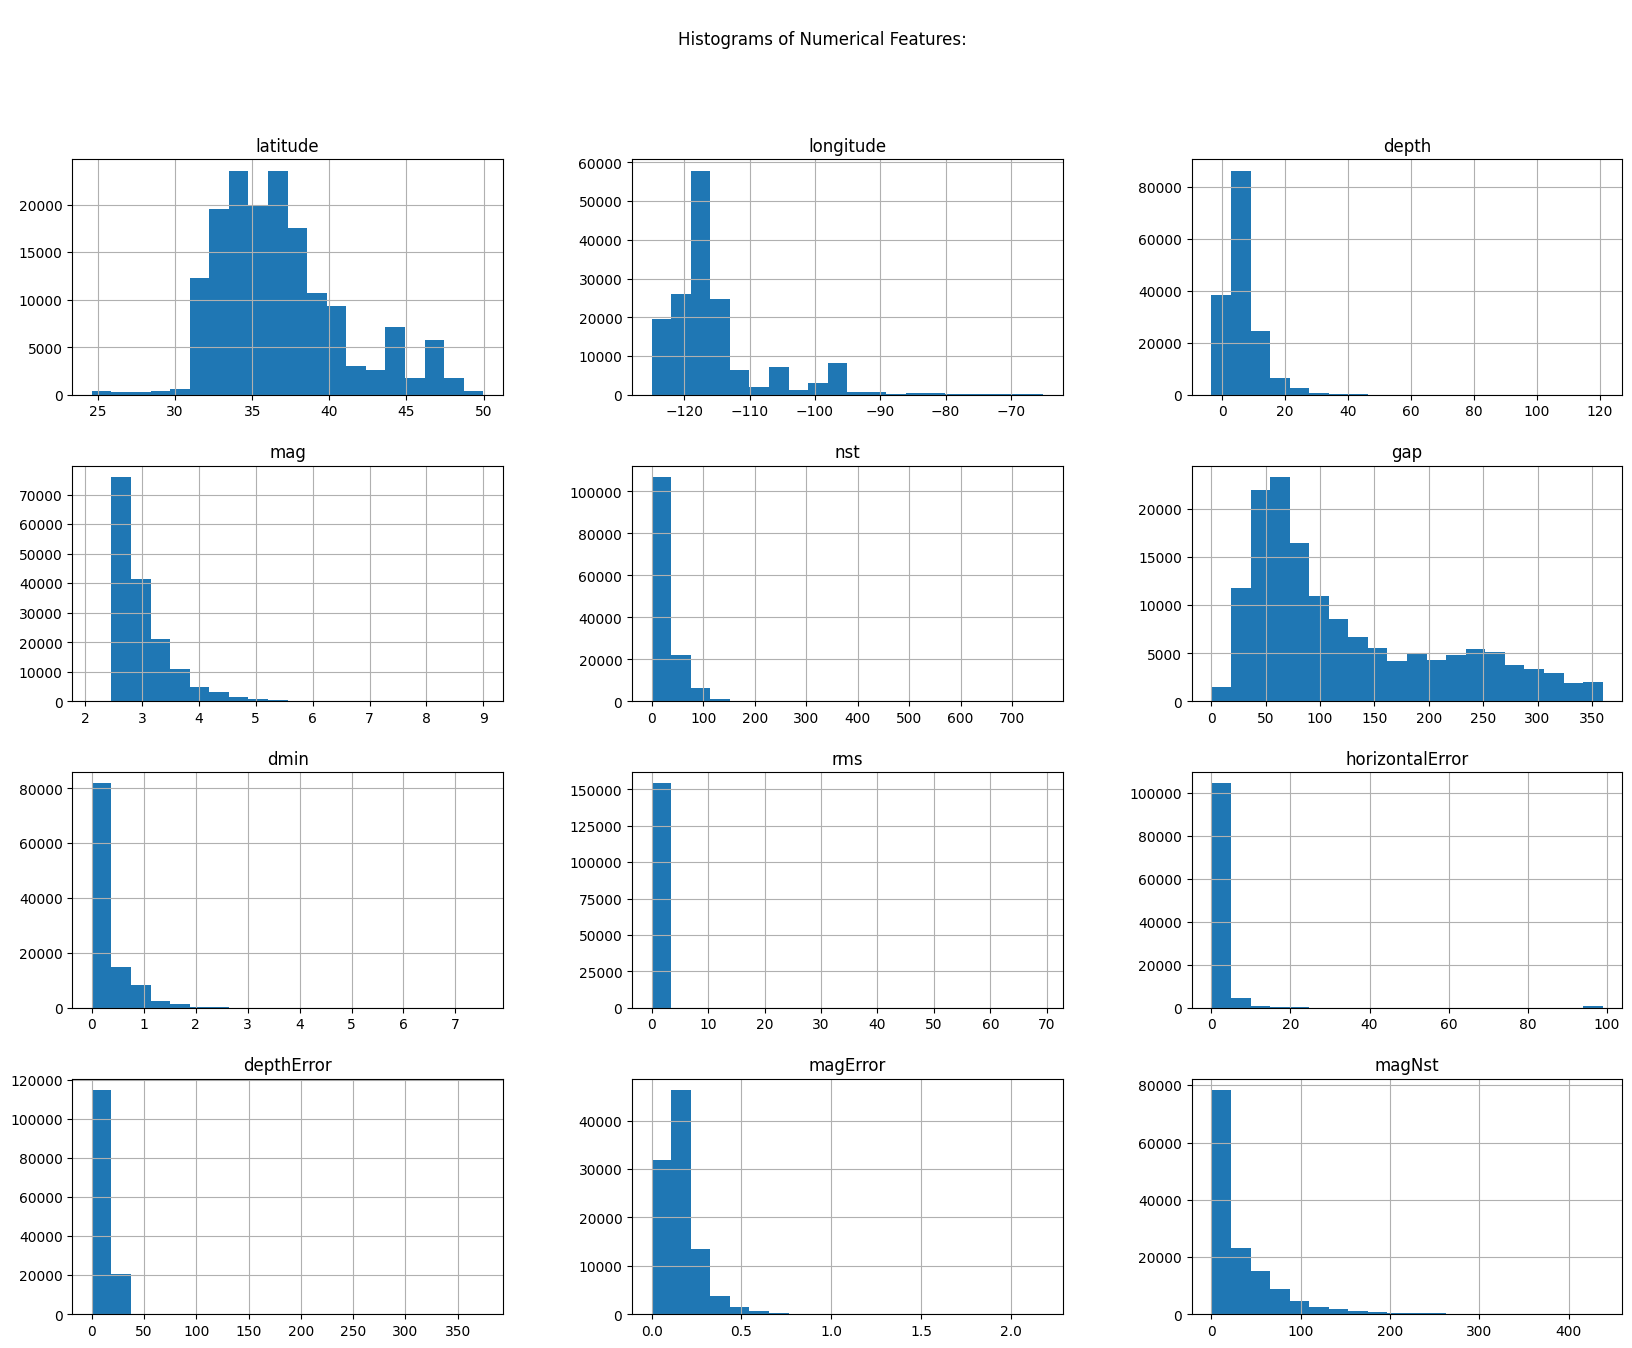

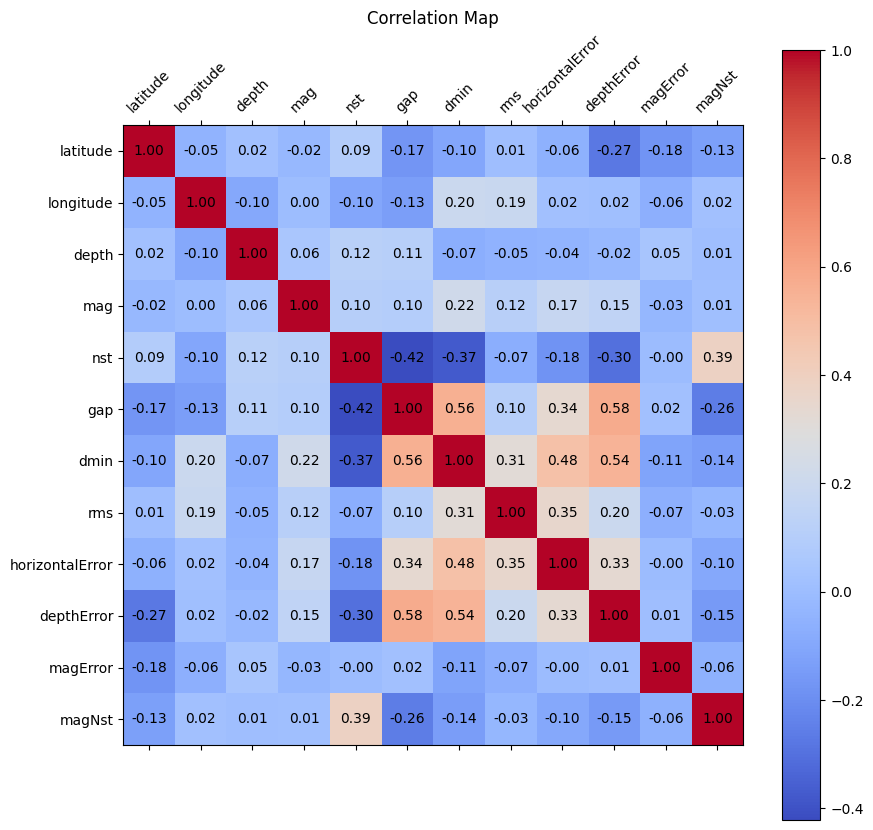

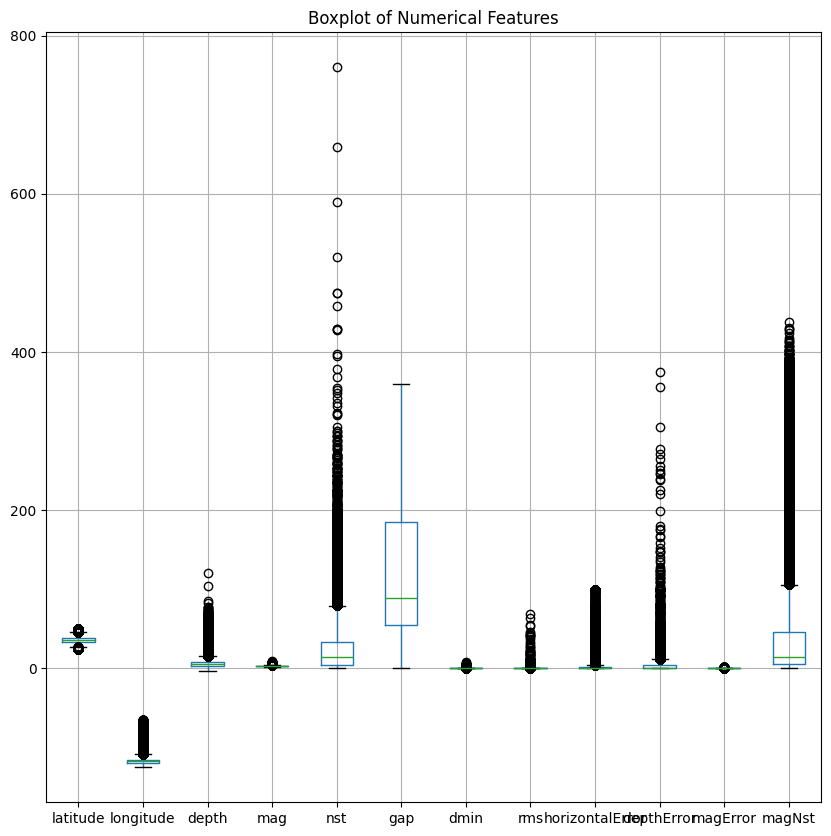

In [3]:
import pandas
import matplotlib.pyplot as plot

# Load dataset
data = pandas.read_csv( "all-raw-dataset.csv" )

### Inspect dataset
inspect = False

if inspect:
	print(  "Total missing values per column/feature:", data.isnull().sum()  )

### Visualize dataset
histrogram = True
correlation = True
boxplot = True

# Histogram
if histrogram:
	data.hist(  bins = 20, figsize = ( 20, 15 )  )
	plot.suptitle(  "\nHistograms of Numerical Features:"  )

# Correlation Matrix
if correlation:
	corr_matrix = data.corr(  numeric_only = True  )

	fig, ax = plot.subplots(  figsize=( 10, 10 )  )
	cax = ax.matshow(  corr_matrix, cmap = "coolwarm"  )
	fig.colorbar(  cax  )

	plot.xticks(  range(  len(  corr_matrix.columns  ) ), corr_matrix.columns, rotation = 45  )
	plot.yticks(  range(  len(  corr_matrix.columns  ) ), corr_matrix.columns  )
	for i in range(  len(  corr_matrix.columns  ) ):
		for j in range(  len(  corr_matrix.columns  ) ):
			ax.text(  j, i, f"{corr_matrix.iloc[ i, j ]:.2f}", va = "center", ha = "center"  )
	plot.title(  "Correlation Map"  )
	plot.show()

# Box plot
if boxplot:
	numeric_cols = list( data.select_dtypes(  include = ['int64', 'float64']  ).columns )

	plot.figure(  figsize = ( 10, 10 )  )
	data.boxplot(  column = numeric_cols, vert = True  )
	plot.title(  "Boxplot of Numerical Features"  )
	plot.show()

#### Insights from correlation map:
- gap, nest, and dmin are strongly correlated. More stations ( nst ) reduce gap and are closer to the event ( lower dmin )
- Fewer stations = higher gap and higher distance
- depthError, horizontalError, gap, and dmin are moderately correlated. Poorly covered or distant events lead to higher errors in location and depth.
- mag does not strongly correlate with other features. Magnitude is independent of these parameters, which is scientifically valid since magnitude depends on energy released, not the event's location and geometry.
- Latitude and longtitude have very low correlation with other features.

#### Prepare the Data for Machine Learning

In [5]:
import numpy
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Remove duplicates
data = pandas.read_csv( "all-raw-dataset.csv" ).drop_duplicates()

# Keep only "earthquake" types
if 'type' in data.columns:
	data = data[data['type'] == 'earthquake']
	data = data.drop( columns=['type'] )

# Drop useless columns
useless_columns = [
	'id', 'place', 'status', 'net', 'updated', 'locationSource', 'magSource', 'magType', 'depth'
]
data = data.drop( columns=[col for col in useless_columns if col in data.columns] )

# Convert 'time' column to useable datetime
if 'time' in data.columns:
	data['time'] = pandas.to_datetime( data['time'], errors='coerce' )
	data['year'] = data['time'].dt.year
	data['month'] = data['time'].dt.month
	data['day'] = data['time'].dt.day
	data['hour'] = data['time'].dt.hour
	data['minute'] = data['time'].dt.minute
	data = data.drop( columns=['time'] )  # drop original string time
	
# Handle missing values
for col in data.columns:
	if data[ col ].isnull().sum() > 0:
		if data[ col ].dtype == "object":
			# If categorical, fill with mode
			data[ col ] = data[ col ].fillna(  data[ col ].mode()[0]  )
		else:
			# If numerical, fill with median
			data[ col ] = data[ col ].fillna(  data[ col ].median() )

# Filter for high quality data
filters = (
	# Number of stations to locate the event
	( data['nst'] >= 5 ) &
	# Number of stations to calculate mag
	( data['magNst'] >= 5 ) &
	# Error in horizontal location (km): Low error -> accurate epicenter
	( data['horizontalError'] <= 5.0 ) &
	# Error in depth estimate (km): Accurate depth for interpreting mag
	( data['depthError'] <= 5.0 ) &
	# Largest angular gap between sensors (degrees): Lower -> better coverage
	( data['gap'] <= 180 ) &
	# Distance to nearest station: closer stations -> better readings
	( data['dmin'] <= 1.0 ) &
	# Root mean square of residuals: Lower -> better
	( data['rms'] <= 1.5 ) &
	# Uncertainty in magnitude
	( data['magError'] < 0.5 )
)
data = data[ filters ]

# 🔹 One-hot encode remaining categorical columns ( e.g., magType )
data = pandas.get_dummies( data, columns=data.select_dtypes( include=['object'] ).columns, drop_first=True )
	
# Remove outliers using Z-Score
numeric_cols = data.select_dtypes( include=[numpy.number] ).columns
z_scores = numpy.abs( zscore( data[numeric_cols] ) )
data = data[( z_scores < 3 ).all( axis=1 )]  # Keep rows with all Z-scores < 3

# Feature scaling ( Exclude Targets from Scaling )
target_variables = [
	"latitude", "longitude", "mag", "year", "day", "hour", "month", "minute"
] # Do not scale
feature_columns = [col for col in numeric_cols if col not in target_variables]

scaler = StandardScaler()
data[feature_columns] = scaler.fit_transform( data[feature_columns].astype( 'float64' ) )

# Save preprocessed data
data.to_csv( "preprocessed_data.csv", index=False )